In [277]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
from nltk.tokenize import WhitespaceTokenizer
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report
import string
import re

In [230]:
def load_text():
    train = pd.read_csv('data/evo_train_clean.csv.gz', compression='gzip', index_col='id')['NAME']
    test = pd.read_csv('data/evo_test_clean.csv.gz', compression='gzip', index_col='id')['NAME']
    return pd.concat([train, test])

In [231]:
def load_data():
    train = pd.read_csv('data/evo_train_clean.csv.gz', compression='gzip', index_col='id')
    categories = pd.read_csv('data/categories_parsed.csv.gz', compression='gzip', index_col='GROUP_ID')
    data = train.join(categories, on='GROUP_ID')
    return data

In [232]:
data = load_data()
texts = load_text()
data['NAME'] = data['NAME']
data.head()

,NAME,GROUP_ID,category,sub_category
id,,,,
0,пиво жигулевский number литр св,35,Алкоголь,"Пиво, слабоалкогольные напитки"
1,соус томатный буздяк number год татарский number,6,Прод,Продукты питания
2,сигарета esse ss exchange,7,Непрод,Табачные изделия
3,петрушка,6,Прод,Продукты питания
4,пиво ягерь,35,Алкоголь,"Пиво, слабоалкогольные напитки"


In [218]:
t = WhitespaceTokenizer()

def tokenize(series, tokenizer):
    return series.apply(lambda row: tokenizer.tokenize(row)).values

In [279]:
def corpus(data, isTrain=True):
    t = WhitespaceTokenizer()
    if isTrain:
        for index, row in data.iterrows():
            yield TaggedDocument(t.tokenize(row['NAME']), row['category'])
    else:
        for index, row in data.iterrows():
            yield t.tokenize(row['NAME'])

In [219]:
# sentences = tokenize(texts, t)
# model = Word2Vec(sentences=sentences, min_count=1, workers=4, size=200, seed=42)

In [220]:
def sentence_vec(sentence, model, tokenizer):
    words = tokenizer.tokenize(sentence)
    return np.sum([model[w] for w in words], axis=0)

In [221]:
def sentences_to_vec(series):
    return series.apply(lambda row: sentence_vec(row, model, t))

In [299]:
def prepare_data(data):
    X = data['NAME']
    y = data['category']
    return train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data, data['category'], test_size=0.3, random_state=42)
X_train = list(corpus(X_train, isTrain=True))
X_test = list(corpus(X_test, isTrain=False))
model = Doc2Vec(size=20, workers=4)
model.build_vocab(X_train)
model.train(X_train)

2267325

In [300]:
X_train_targets = [model.infer_vector(doc.words, steps=50) for doc in X_train]
X_test_targets = [model.infer_vector(doc, steps=50) for doc in X_test]

In [223]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

def show_metrics(y_true, y_pred, y_pred_proba):
    print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
    print("LogLoss: {}".format(log_loss(y_true, y_pred_proba)))
    print(classification_report(y_true, y_pred))
    cnf_matrix = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cnf_matrix, y_true.unique())

In [291]:
def logistic(X_train, y_train, X_test, y_test):
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    
    pred = clf.predict(X_test)
    pred_proba = clf.predict_proba(X_test)
    
    show_metrics(y_test, pred, pred_proba)
    
#     pred_df = pd.DataFrame(pred, index=X_test.index,columns=['predicted'])
#     pred_df['real'] = y_test
#     pred_df['NAME'] = data.ix[X_test.index, 'NAME']
#     errors = pred_df[pred_df['real'] != pred_df['predicted']]
    
#     return errors

Accuracy: 0.9217090344909894
LogLoss: 0.27498993875143063


/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                           precision    recall  f1-score   support

                 Алкоголь       0.96      0.89      0.92      3583
                   Непрод       0.91      0.98      0.95     11214
Позиция по свободной цене       0.00      0.00      0.00         4
                     Прод       0.90      0.62      0.73      1774
                      н/д       0.98      0.61      0.75       183

              avg / total       0.92      0.92      0.92     16758

Confusion matrix, without normalization
[[ 3199   354     0    30     0]
 [   84 11038     0    90     2]
 [    0     1     0     3     0]
 [   66   610     0  1098     0]
 [    0    70     0     2   111]]


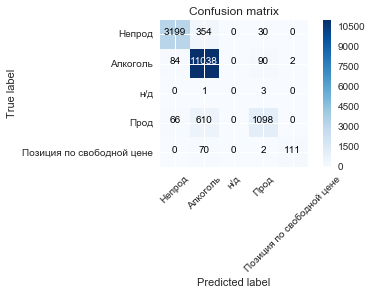

In [301]:
errors = logistic(X_train_targets, y_train, X_test_targets, y_test)